In [1]:
import wandb
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib
import warnings

from botorch.utils.multi_objective import pareto

from lambo.candidate import pdb_to_residues

warnings.filterwarnings("ignore")
sns.set(style='whitegrid', font_scale=1.75)

## Utility functions

In [2]:
def runs_to_plot_df(wandb_runs):
    history = [r.scan_history() for r in runs]
    print(len(history))
    df = pd.concat([pd.DataFrame(h) for h in history])
    log_prefix='proxy_rfp/candidates'
    df = df.rename(columns={
    f'{log_prefix}/cand_uuid': 'cand_uuid',
    f'{log_prefix}/cand_seq': 'cand_seq',
    f'{log_prefix}/cand_ancestor': 'cand_ancestor',
    f'{log_prefix}/round_idx': 'round_idx',
    f'{log_prefix}/obj_val_0': 'obj_val_0',
    f'{log_prefix}/obj_val_1': 'obj_val_1',
    })
    df = df.sort_values('obj_val_0')
    df = df.replace((np.inf, -np.inf), np.nan)
    df = df.dropna(subset=['round_idx'])
    targets = torch.stack((
        torch.tensor(-df.obj_val_0.values),
        torch.tensor(-df.obj_val_1.values),
    ), dim=-1)
    df['is_non_dominated'] = pareto.is_non_dominated(targets).bool().numpy()
    return df


def plot_result(ax, base_wild_types, df, normalize=True, alpha_temp=2.,
               show_intermediate=False):
    if normalize:
        x_min = base_wild_types.SASA.min()
        x_range = base_wild_types.SASA.max() - x_min

        y_min = (-base_wild_types.foldx_total_energy).min()
        y_range = (-base_wild_types.foldx_total_energy).max() - y_min
    else:
        x_min = y_min = 0.
        x_range = y_range = 1.

    for wild_name, color in zip(base_wild_types.Name.unique(), sns.color_palette()): 
        for opt_round in df.round_idx.unique():
            alpha = math.exp((opt_round - df.round_idx.max()) / alpha_temp)
            mask = (
                (df.round_idx == opt_round) &
                (df.cand_ancestor == wild_name) &
                (df.obj_val_0 < float('inf')) &
                (df.obj_val_1 < float('inf'))
            )
            select = df[mask]
            x_val = (-select.obj_val_0 - x_min) / x_range
            y_val = (-select.obj_val_1 - y_min) / y_range
                
            alpha = 0.1
            if show_intermediate:
                ax.scatter(x_val, y_val, alpha=alpha, s=16, zorder=1,
                           edgecolors=color, facecolors='none', linewidth=2)

        # plot starting points
        mask = (base_wild_types.Name == wild_name)
        select = base_wild_types[mask]
        x_val = (select.SASA - x_min) / x_range
        y_val = (-select.foldx_total_energy - y_min) / y_range
        ax.scatter(x_val, y_val, s=64, linewidth=4, zorder=4,
                   label=wild_name, edgecolors=color, facecolors='none')
        
        mask = (
            (df.is_non_dominated == 1) &
            (df.cand_ancestor == wild_name) &
            (df.obj_val_0 < float('inf')) &
            (df.obj_val_1 < float('inf'))
        )
        select = df[mask]
        x_val = (-select.obj_val_0 - x_min) / x_range
        y_val = (-select.obj_val_1 - y_min) / y_range
        ax.scatter(x_val, y_val, marker='x', zorder=4, linewidth=4, s=64)
        

    x_old_frontier = (base_wild_types.SASA - x_min) / x_range
    y_old_frontier = (-base_wild_types.foldx_total_energy - y_min) / y_range
    ax.plot(x_old_frontier, y_old_frontier, color='black', linestyle='--', label='Old Frontier',
            zorder=3, linewidth=2)

    mask = (df.is_non_dominated == 1)
    select = df[mask]
    x_new_frontier = (-select.obj_val_0 - x_min) / x_range
    y_new_frontier = (-select.obj_val_1 - y_min) / y_range
    ax.plot(x_new_frontier, y_new_frontier, color='black', label='New Frontier', zorder=3,
            linewidth=2)

    ax.set_xlabel('SASA')
    ax.set_ylabel('Stability')
#     ax.legend(loc='upper right')
    plt.tight_layout()
    
    return ax

## Initial non-dominated RFPs

In [3]:
rfp_known_structures = pd.read_csv('../lambo/assets/fpbase/rfp_known_structures.csv')

seq_len_mask = np.array([len(x) <=  244 for x in rfp_known_structures.foldx_seq])
rfp_known_structures = rfp_known_structures[seq_len_mask]
rfp_known_structures.reset_index(inplace=True)

target_data = np.stack([
        rfp_known_structures.SASA.values,
        -rfp_known_structures.foldx_total_energy.values,
    ], axis=-1)
pareto_mask = pareto.is_non_dominated(torch.tensor(target_data))
mask = pd.Series(pareto_mask.numpy())
base_wild_types = rfp_known_structures[mask]
base_wild_types = base_wild_types.sort_values('SASA')

api = wandb.Api()

## Optimized non-dominated RFPs

Obtained via optimization with LaMBO

In [4]:
fig_name = "pareto-frontier-viz_lambo_v0.2.0"

runs = api.runs(
    path='samuelstanton/lambo',
    filters={
        'config.config/exp_name': 'bbo_benchmark',
        'config.config/version': 'v0.2.0',
        'config.config/optimizer/_target_': 'lambo.optimizers.lambo.LaMBO',
        'config.config/task/_target_': 'lambo.tasks.proxy_rfp.proxy_rfp.ProxyRFPTask',
        'config.config/surrogate/_target_': 'lambo.models.gp_models.MultiTaskExactGP',
        'config.config/acquisition/_target_': 'lambo.acquisitions.ehvi.NoisyEHVI',
    }
)

In [5]:
overwrite_df = False

try:
    df = pd.read_csv(f'./assets/{fig_name}.csv')
    print('loaded saved data')
except FileNotFoundError:
    df = runs_to_plot_df(runs)
    overwrite_df = True
    
if overwrite_df:
    df.to_csv(f'./assets/{fig_name}.csv', index=None)

loaded saved data


Text(0.5, 1.0, 'RFP Pareto Frontier')

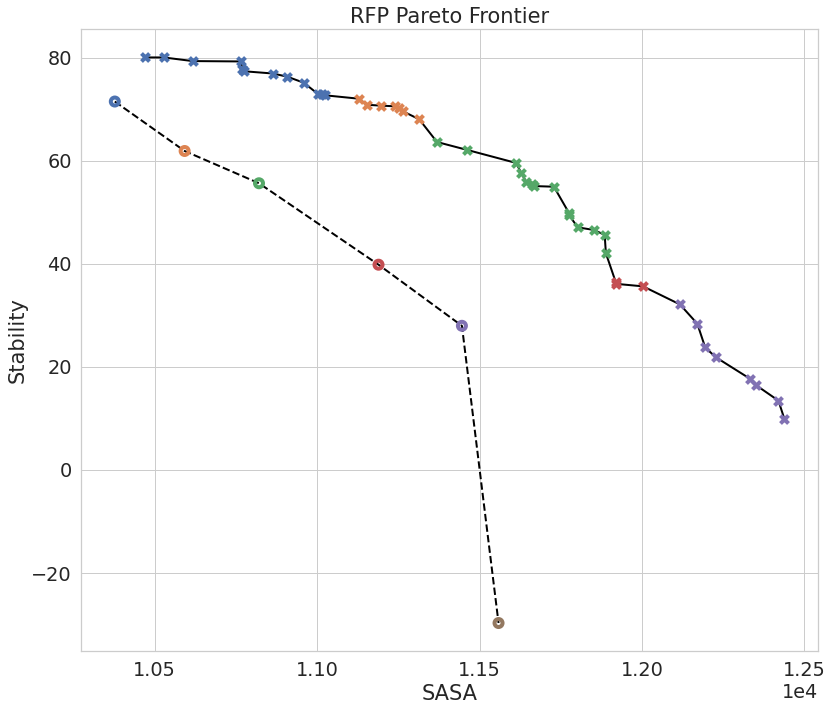

In [6]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
ax = plot_result(ax, base_wild_types, df, normalize=False)

ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.tight_layout()
plt.title('RFP Pareto Frontier')

# plt.savefig(f'./figures/{fig_name}.pdf')